# Modelos estatísticos com amostragem

## Importação de bibliotecas

In [22]:
!pip install nlp_utils
!pip install wordcloud

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import string

import nlp_utils

'''Features'''
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn import preprocessing
#from sklearn.compose import ColumnTransformer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist, word_tokenize
nltk.download('punkt')

'''Classificadores'''
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.multiclass import OneVsRestClassifier

'''Métricas/avaliação'''
from sklearn.model_selection import GridSearchCV  # Busca os melhores parâmetros para o treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, \
    plot_confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

'''Persistência'''
from joblib import dump, load

'''Plotagem'''
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

from pprint import pprint
from time import time
import logging

print(__doc__)
# Display progress logs on stdout (Ajuda a entender em que ponto está a execução. Útl para as combinações feitas pelo GridAearch)
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

Plotagem


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Carregar os dados

In [24]:
'''
from google.colab import drive
drive.mount('/content/drive')
data_path = "drive/MyDrive/data/balanced"
model_path = "drive/MyDrive/models"
'''
data_path = "../data/70-15-15"
model_path = "../models"

## Carrega dataset de treino, teste e validação

In [25]:
df_model = pd.read_csv(data_path+'/comunicados.csv', sep=',') 
df_train = pd.read_csv(data_path+'/comunic_treino_aug.csv', sep=',')
df_test = pd.read_csv(data_path+'/comunic_teste.csv', sep=',')

In [26]:
# Fonte: https://github.com/netoferraz/o-eu-analitico/blob/master/_notebooks/2020-07-26-gov-data-product-p3.ipynb
def remove_stopwords(data):
  stop_words = stopwords.words('portuguese')
  stop_words.append('r')
  stop_words.append('dt')
  stop_words.append('pois')
  for index, row in data.iterrows():
    words = word_tokenize(row['text'], language='portuguese')
    # remoção de pontuação
    words = list(filter(lambda token: token not in string.punctuation, words))
    words = [word for word in words if word not in stop_words]
    data.at[index,'text'] = ' '.join(words)
  return data, stop_words

def make_word_cloud(series: pd.Series, **kwargs):
    stopwords = kwargs.get('stopwords')
    corpus_normativos = " ".join(series)
    tokenize_corpus = word_tokenize(corpus_normativos)
    if stopwords:
        print(len(stopwords))
        wordcloud = WordCloud(background_color="white", width=1024, height=768, stopwords=stopwords, margin=0).generate(corpus_normativos)
    else:
        wordcloud = WordCloud(background_color="white", width=1024, height=768, margin=0).generate(corpus_normativos)
    #show
    plt.figure(figsize=[15, 9])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud


In [27]:
df_model

,text,label
0,não cumpriu o período de dias úteis pra cadast...,4
1,denúncia á cpl da prefeitura municipal de ribe...,4
2,porque não consta documentação da licitação pr...,4
3,o vereador presidente da câmara municipal de v...,9
4,denunciar a câmara de vereadores de joaquim pi...,2
...,...,...
1612,exmo sr conselheiro ouvidor do egrégio tribuna...,12
1613,informe que mandei um email com anexos onde co...,2
1614,comunico esse tribunal que a atual gestão da c...,2
1615,relata que o prefeito de dom expedito lopes en...,2


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


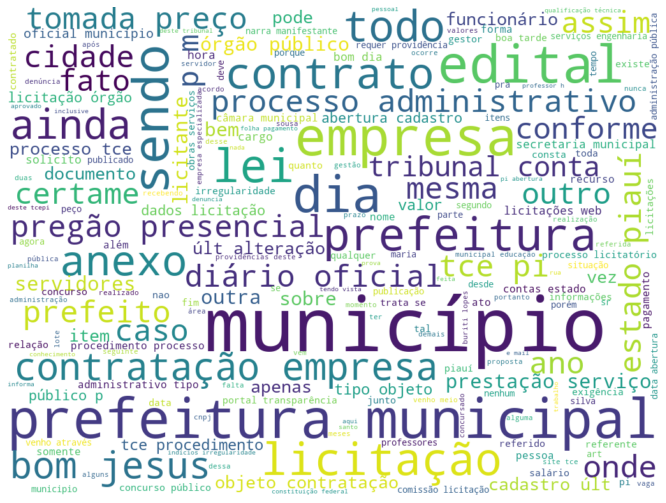

In [28]:
# Word cloud antes de normalização
nltk.download('stopwords')
df_model, stop_words = remove_stopwords(df_model)
make_word_cloud(df_model.text)

In [8]:
def frequency_plot(series: pd.Series, **kwargs):
    stopwords = kwargs.get('stopwords')
    corpus_normativos = " ".join(series)
    tokenize_corpus = word_tokenize(corpus_normativos)
    if stopwords:
        tokenize_corpus = [w for w in tokenize_corpus if w not in stopwords]
    plt.figure(figsize=(10,5))
    fd = FreqDist(tokenize_corpus)
    fd.plot(30,title = "Palavras x Frequência",cumulative=False)

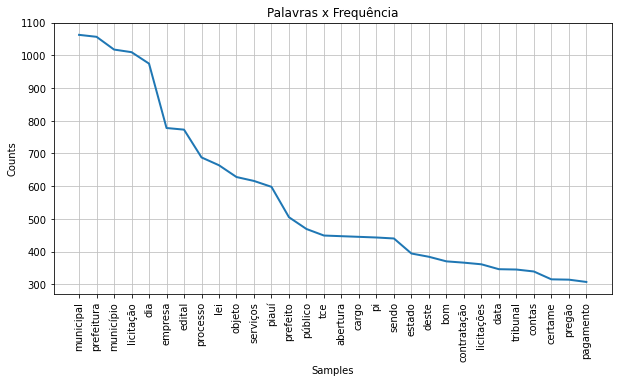

In [9]:
# Distribuição de frequência de palavras antes da normalização
frequency_plot(df_model.text)

### Teste de algoritmos com parâmetros default

In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(df_train.label), y= df_train.label)
class_weights = dict(zip(np.unique(df_train.label), class_weights))
class_weights

{0: 1.1276923076923078,
 1: 1.1276923076923078,
 2: 1.1276923076923078,
 3: 1.1276923076923078,
 4: 0.42394447657605555,
 5: 1.1276923076923078,
 6: 1.1276923076923078,
 7: 1.1276923076923078,
 8: 1.1276923076923078,
 9: 1.1276923076923078,
 10: 1.1276923076923078,
 11: 1.1276923076923078,
 12: 1.1276923076923078}

In [11]:
#Preliminary model evaluation using default parameters
#Creating a dict of the models
model_dict = {'Stochastic Gradient Descent' : SGDClassifier(random_state=3)
              ,'Random Forest': RandomForestClassifier(random_state=3)
              ,'Decision Tree': DecisionTreeClassifier(random_state=3)
              ,'Naive Bayes': MultinomialNB() #ComplementNB()
              ,'Logistic Regression': LogisticRegression(random_state=3)
              ,'K Nearest Neighbor': KNeighborsClassifier()
             }

def score_df(model_name, y_real, y_pred, average='weighted'):
    model_name_list, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []

    model_name_list.append(model_name)
    ac_score_list.append(accuracy_score(y_real, y_pred))
    p_score_list.append(precision_score(y_real, y_pred, average=average))
    r_score_list.append(recall_score(y_real, y_pred, average=average))
    f1_score_list.append(f1_score(y_real, y_pred, average=average))
    
    df = pd.DataFrame([model_name_list, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
    df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
    return df

#Function to get the scores for each model in a df
def model_score_df(X_train, X_test, y_train, y_test):   
    model_comparison_df = pd.DataFrame(columns= ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'])
    for k,v in model_dict.items():   
        print('Model: {}...'.format(k))
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        model_comparison_df = model_comparison_df.append(score_df(k, y_test, y_pred), ignore_index=True)

    model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

In [12]:
# Observação durante o desenvolvimento usa-se os datasets treino e validação. 
# Na fase de produção é que se usa o dataset teste

tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), min_df = 1, max_df = .80)

X_train = tfidf_vectorizer.fit_transform(np.array(df_train.text.astype('str')))
X_test = tfidf_vectorizer.transform(np.array(df_test.text.astype('str')))
y_train = df_train.label
y_test = df_test.label


model_score_df(X_train, X_test, y_train, y_test)


Model: Stochastic Gradient Descent...


/tmp/ipykernel_8346/1109388018.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_comparison_df = model_comparison_df.append(score_df(k, y_test, y_pred), ignore_index=True)


Model: Random Forest...


/tmp/ipykernel_8346/1109388018.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_comparison_df = model_comparison_df.append(score_df(k, y_test, y_pred), ignore_index=True)


Model: Decision Tree...


/tmp/ipykernel_8346/1109388018.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_comparison_df = model_comparison_df.append(score_df(k, y_test, y_pred), ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_8346/1109388018.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_comparison_df = model_comparison_df.append(score_df(k, y_test, y_pred), ignore_index=True)


Model: Naive Bayes...
Model: Logistic Regression...
Model: K Nearest Neighbor...


/tmp/ipykernel_8346/1109388018.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_comparison_df = model_comparison_df.append(score_df(k, y_test, y_pred), ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/tmp/ipykernel_8346/1109388018.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_compariso

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Stochastic Gradient Descent,0.82716,0.829934,0.82716,0.816001
1,Random Forest,0.814815,0.817714,0.814815,0.795338
4,Logistic Regression,0.8107,0.817091,0.8107,0.793926
5,K Nearest Neighbor,0.687243,0.7177,0.687243,0.691619
2,Decision Tree,0.658436,0.682216,0.658436,0.665108
3,Naive Bayes,0.633745,0.640561,0.633745,0.560331


In [13]:
from sklearn.utils import class_weight

X_train = tfidf_vectorizer.fit_transform(np.array(df_train.text.astype('str')))
X_test = tfidf_vectorizer.transform(np.array(df_test.text.astype('str')))
y_train = df_train.label
y_test = df_test.label

sample = class_weight.compute_sample_weight('balanced', y_train)

#Classifier Naive Bayes
naive = MultinomialNB()
naive.fit(X_train,y_train, sample_weight=sample)
predictions_NB = naive.predict(X_test)

## Busca de melhores parâmetros
### Random Forest

In [14]:
model_dict.get('Random Forest').get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}

In [15]:
#RF

params = {'bootstrap': [True, False],
 'max_depth': [None, 10, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 4],
 'n_estimators': [100, 200, 500],
 'random_state': [42]}


clf = RandomForestClassifier()


gridsearch = GridSearchCV(clf,
                          params, 
                          cv=3,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X_train, y_train)
y_pred = gridsearch.best_estimator_.predict(X_test)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [16]:
print(f'accuracy_score: {accuracy_score(y_test, y_pred)}')
print(f'precision_score:{precision_score(y_test, y_pred, average="weighted")}')
print(f'recall_score:   {recall_score(y_test, y_pred, average="weighted")}')
print(f'f1_score:       {f1_score(y_test, y_pred, average="weighted")}')
gridsearch.best_estimator_.get_params()

accuracy_score: 0.8189300411522634
precision_score:0.812150567867154
recall_score:   0.8189300411522634
f1_score:       0.7986649073873978


{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


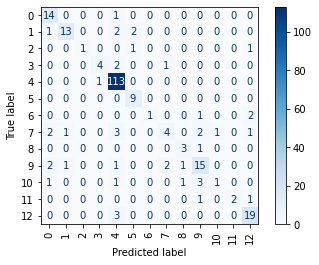

In [17]:
#print("Matriz de confusão:\n", \
#    plot_confusion_matrix(gridsearch.best_estimator_, X_test, y_test, xticks_rotation='vertical', cmap=plt.cm.Blues))
display = plot_confusion_matrix(gridsearch.best_estimator_, X_test, y_test, xticks_rotation='vertical', cmap=plt.cm.Blues)
plt.show()

### Stochastic Gradient Descent

In [18]:
model_dict.get('Stochastic Gradient Descent').get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 3,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [19]:
#SGD
params = {'alpha': [0.0001, 0.00001, 0.000001],
'penalty': ['l2', 'elasticnet'],
'loss': ['log', 'hinge'],
'max_iter': [20, 50, 100]}
          
clf = SGDClassifier(random_state=3)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=3,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X_train, y_train)
y_pred = gridsearch.best_estimator_.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [20]:
print('Acurácia: ', accuracy_score(y_test, y_pred))
print('Precisão: ',precision_score(y_test, y_pred, average='weighted'))
print('Recall:   ', recall_score(y_test, y_pred, average='weighted'))
print('F1-Score: ', f1_score(y_test, y_pred, average='weighted'))
gridsearch.best_estimator_.get_params()

Acurácia:  0.8271604938271605
Precisão:  0.8276127751917066
Recall:    0.8271604938271605
F1-Score:  0.8161744241015815


{'alpha': 1e-05,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log',
 'max_iter': 20,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 3,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


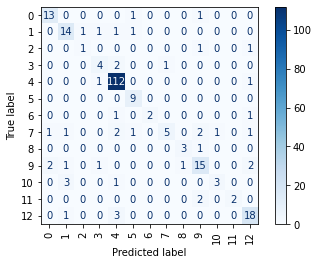

In [21]:
display = plot_confusion_matrix(gridsearch.best_estimator_, X_test, y_test, xticks_rotation='vertical', cmap=plt.cm.Blues)
plt.show()